In [1]:
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yigii\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('SMSSpamCollection.txt', sep='\t', names=['label', 'message'])
df.head(2)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
df[df.duplicated()]

,label,message
103,ham,As per your request 'Melle Melle (Oru Minnamin...
154,ham,As per your request 'Melle Melle (Oru Minnamin...
207,ham,"As I entered my cabin my PA said, '' Happy B'd..."
223,ham,"Sorry, I'll call later"
326,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


In [7]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [8]:
df['len'] = df.message.apply(len)
df.head(2)

,label,message,len
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29


<AxesSubplot: xlabel='len', ylabel='Count'>

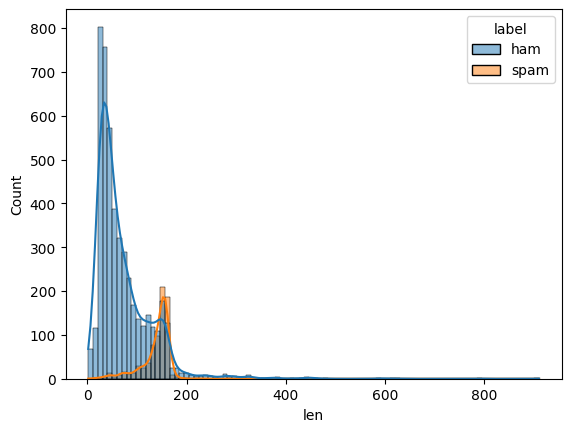

In [9]:
sns.histplot(data=df, x='len', hue='label', kde=True)

In [10]:
df[df['message'].str.contains('\$')].label.value_counts()

ham     14
spam     4
Name: label, dtype: int64

In [11]:
def remove_punctuation(text):
        message = []
        for x in text:
            if x in string.punctuation:
                pass
            else:
                message.append(x)
        message = ''.join(message)
        
        return message
    
def remove_stopwords(text):
    words= []
    for x in text.split():
        if x.lower() in stopwords.words('english'):
            pass
        else:
            words.append(x)
    return words

def token_words(text):
    text = remove_punctuation(text)
    words = remove_stopwords(text)
    return words

In [12]:
message = 'Sample message! Notice: it has a punctuation.'

words = token_words(message)
words

['Sample', 'message', 'Notice', 'punctuation']

In [13]:
df['message'].head(4).apply(token_words)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
Name: message, dtype: object

In [14]:
bow_transformer = CountVectorizer(analyzer=token_words).fit(df.message)

In [15]:
messages_bow = bow_transformer.transform(df.message)

In [16]:
print(f'Shape of sparse matrix {messages_bow.shape}')

Shape of sparse matrix (5572, 11425)


In [17]:
sparsity = (100. * messages_bow.nnz / (messages_bow.shape[0]*messages_bow.shape[1]))
sparsity

0.07940295412668218

In [18]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [19]:
messages_tfidf = tfidf_transformer.transform(messages_bow)

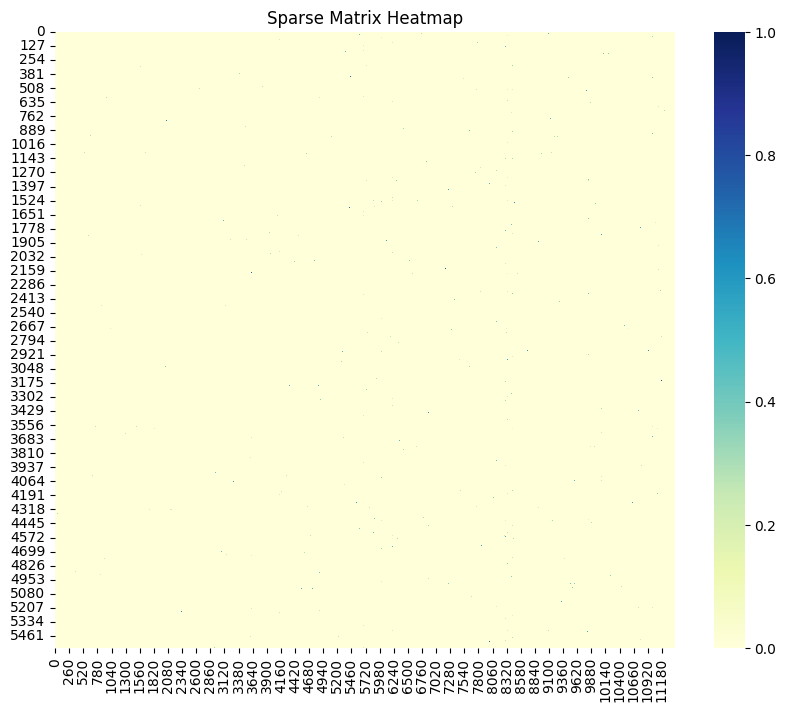

In [20]:
# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(messages_tfidf.toarray(), cmap="YlGnBu", annot=False)
plt.title("Sparse Matrix Heatmap")
plt.show()

In [21]:
messages_tfidf

<5572x11425 sparse matrix of type '<class 'numpy.float64'>'
	with 50548 stored elements in Compressed Sparse Row format>

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, accuracy_score

In [23]:
model = MultinomialNB()
X_train, X_test, y_train, y_test = train_test_split(messages_tfidf, df.label, test_size=0.2)
model.fit(X_train, y_train)

MultinomialNB()

In [24]:
preds = model.predict(X_test)

In [25]:
acc = accuracy_score(y_test, preds)
acc

0.9641255605381166

In [26]:
recall = recall_score(y_test, preds, pos_label='spam')
recall

0.7297297297297297

In [27]:
precision = precision_score(y_test, preds, pos_label='spam')
precision

1.0